In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from numpy import linalg as LA
import copy
import networkx as nx
import random

plt.rcParams.update({'font.size': 17})

import matplotlib.ticker as ticker


from scipy.stats import pearsonr



In [13]:
#Read Supra adjacency matrix

corr_data = abs(pd.read_csv("../data/insulin_eQTL_spearman_corr_matrix_with_snap_removed_CF_lt_R_latest_10k_partial_cov.csv"))

corr_data

,RPL10P15,CYP17A1,RP1-197B17.7,PHF24,GNG3,NPPA,SYCE1,RP11-286H14.4,RP11-187C18.3,RPL29P12,...,STX5.1,EIF5A.1,MAPK7.1,HIPK1.1,STK36.1,POMGNT1.1,RRS1.1,NDUFAF7.1,PIK3CD.1,CAP1.1
RPL10P15,1.000000,0.053434,0.043760,0.050054,0.035954,0.046822,0.035239,0.118408,0.005489,0.194413,...,0.000727,0.070111,0.073198,0.065885,0.031846,0.003094,0.060211,0.075776,0.047379,0.066268
CYP17A1,0.053434,1.000000,0.040780,0.010423,0.114900,0.010247,0.052217,0.036745,0.136705,0.172469,...,0.007358,0.125375,0.057436,0.041594,0.071905,0.098046,0.037525,0.060133,0.018366,0.050969
RP1-197B17.7,0.043760,0.040780,1.000000,0.053669,0.104990,0.109487,0.113065,0.001620,0.075315,0.003869,...,0.014127,0.099711,0.008239,0.014327,0.031850,0.113746,0.032206,0.144107,0.038195,0.176731
PHF24,0.050054,0.010423,0.053669,1.000000,0.238854,0.046769,0.065840,0.034841,0.051371,0.001902,...,0.024330,0.034334,0.037916,0.001487,0.014788,0.052408,0.046394,0.075549,0.013842,0.057242
GNG3,0.035954,0.114900,0.104990,0.238854,1.000000,0.013479,0.028680,0.068333,0.071739,0.024476,...,0.134748,0.007479,0.062852,0.035041,0.045977,0.070340,0.083501,0.060685,0.042746,0.014760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
POMGNT1,0.003094,0.098046,0.113746,0.052408,0.070340,0.051227,0.018045,0.004307,0.041205,0.021201,...,0.065954,0.256484,0.084094,0.000366,0.009958,1.000000,0.096197,0.046823,0.042183,0.231971
RRS1,0.060211,0.037525,0.032206,0.046394,0.083501,0.061765,0.000168,0.039143,0.074213,0.052205,...,0.253314,0.187179,0.146618,0.049679,0.103293,0.096197,1.000000,0.007978,0.070975,0.027322
NDUFAF7,0.075776,0.060133,0.144107,0.075549,0.060685,0.022735,0.059743,0.046151,0.000834,0.062077,...,0.067235,0.044782,0.029135,0.063853,0.046101,0.046823,0.007978,1.000000,0.124829,0.166220
PIK3CD,0.047379,0.018366,0.038195,0.013842,0.042746,0.060825,0.068878,0.037072,0.063950,0.064314,...,0.000115,0.009649,0.080346,0.028597,0.069386,0.042183,0.070975,0.124829,1.000000,0.080262


In [14]:
N = int(corr_data.shape[0])
L = 2
n = int(N/L)
print(N)
print("genes per layer: ", n)

28918
genes per layer:  14459


In [28]:
# Load Insulin producing (source) and responding (target) genes

genes = list(corr_data.columns[:n])
target_genes = list(pd.read_csv('../data/insulin_target_genes_full.csv', header=None).iloc[:,0])
source_genes = list(pd.read_csv('../data/insulin_source_genes_full.csv', header=None).iloc[:,0])

print("Statistics of the ground truth data")
print("Number of genes: ", len(genes))
print("Number of target genes: ", len(target_genes))
print("Number of source genes: ", len(source_genes))
#print(genes)

common_target_genes = np.intersect1d(genes, target_genes)
common_source_genes = np.intersect1d(genes, source_genes)


print("Number of target genes present in the data: ", len(common_target_genes))
print("Number of source genes present in the data: ", len(common_source_genes))

target_genes_indices = [i for i, e in enumerate(genes) if e in common_target_genes]
source_genes_indices = [i for i, e in enumerate(genes) if e in common_source_genes]

print("Number of target genes present in the data: ", len(target_genes_indices))
print("Number of source genes present in the data: ", len(source_genes_indices))

print(target_genes_indices)

Statistics of the ground truth data
Number of genes:  14459
Number of target genes:  6482
Number of source genes:  2860
Number of target genes present in the data:  215
Number of source genes present in the data:  156
Number of target genes present in the data:  215
Number of source genes present in the data:  156
[5, 14, 1098, 1135, 1350, 1435, 1447, 1453, 1641, 1938, 2085, 2087, 2097, 2373, 2384, 2479, 2554, 2560, 2643, 2859, 2883, 3097, 3177, 3317, 3399, 3418, 3611, 3618, 3662, 3717, 3967, 4061, 4255, 4274, 4418, 4549, 4627, 4693, 5121, 5224, 5379, 5483, 5630, 5654, 5713, 6020, 6109, 6111, 6169, 6249, 6258, 6324, 6434, 6630, 6731, 6853, 6860, 6892, 6997, 7176, 7282, 7373, 7394, 7462, 7511, 7596, 7710, 7750, 7843, 7872, 7875, 8066, 8336, 8360, 8454, 8472, 8523, 8584, 8589, 8605, 8665, 8742, 8746, 8764, 8852, 8969, 9157, 9258, 9268, 9363, 9364, 9540, 9592, 9600, 9716, 9730, 9735, 9748, 9761, 9836, 9871, 9933, 10049, 10057, 10089, 10145, 10237, 10241, 10345, 10500, 10560, 10612, 10620,

In [29]:
# Load SNAP data. This includes tissue specific gene-gene connections.


SNAP_data = pd.read_csv("../data/SNAP_data/PPT-Ohmnet_gene_symbols.csv", index_col=0)
#SNAP_data
pancreas_df = SNAP_data.loc[SNAP_data['tissue'] == "pancreas"].values
skeletal_muscle_df = SNAP_data.loc[SNAP_data['tissue'] == "skeletal_muscle"].values

A_SNAP = np.zeros_like(corr_data.values, dtype=np.float32)

#skeletal_muscle_adjacency = np.zeros_like((np.shape(skeletal_muscle_df)[0], 2))
for i in range(np.shape(skeletal_muscle_df)[0]):
    n_offset = n
    try:
        from_gene = int(genes.index(skeletal_muscle_df[i,0])) + n_offset
        to_gene = int(genes.index(skeletal_muscle_df[i,1])) + n_offset    
        A_SNAP[from_gene, to_gene] = 1
        A_SNAP[to_gene, from_gene] = 1
    except:
        print("In skeletal muscle ", skeletal_muscle_df[i, 0], " or ", skeletal_muscle_df[i,1], " not present.")             
    

for i in range(np.shape(pancreas_df)[0]):
    n_offset = 0
    try:
        from_gene = int(genes.index(pancreas_df[i,0])) + n_offset
        to_gene = int(genes.index(pancreas_df[i,1])) + n_offset    
        A_SNAP[from_gene, to_gene] = 1
        A_SNAP[to_gene, from_gene] = 1
    except:
        print("In pancreas ", pancreas_df[i, 0], " or ", pancreas_df[i,1], " not present.")  


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In skeletal muscle  SETDB1  or  H4-16  not present.
In skeletal muscle  SEPTIN9  or  VAPB  not present.
In skeletal muscle  NKX3-2  or  TLE4  not present.
In skeletal muscle  MYOD1  or  RUNX1  not present.
In skeletal muscle  NPM1  or  ATP5F1A  not present.
In skeletal muscle  MRE11  or  FEN1  not present.
In skeletal muscle  RBPMS  or  TENT2  not present.
In skeletal muscle  ATP5F1D  or  ATP5F1C  not present.
In skeletal muscle  PPP1CA  or  PRKACG  not present.
In skeletal muscle  GCK  or  GMIP  not present.
In skeletal muscle  ERCC4  or  H2AX  not present.
In skeletal muscle  TLE5  or  RNF31  not present.
In skeletal muscle  GRB2  or  DENND2B  not present.
In skeletal muscle  FOXA3  or  DSP  not present.
In skeletal muscle  H4-16  or  KDM4A  not present.
In skeletal muscle  OBSL1  or  MRE11  not present.
In skeletal muscle  CREB3  or  BIK  not present.
In skeletal muscle  ACTN3  or  LHX3  not present.
In skeletal muscle  PRKN  or  EPS15  not present.
In skeletal muscle  PRKN  or  NME

In skeletal muscle  HDAC1  or  MYOD1  not present.
In skeletal muscle  SEPTIN7  or  RNF8  not present.
In skeletal muscle  DFFA  or  SEPTIN5  not present.
In skeletal muscle  CIAO3  or  APP  not present.
In skeletal muscle  CDK2  or  ATP5MG  not present.
In skeletal muscle  TAFAZZIN  or  COL6A2  not present.
In skeletal muscle  PSMA2  or  ECPAS  not present.
In skeletal muscle  GRB2  or  H4C2  not present.
In skeletal muscle  ZACN  or  EDA  not present.
In skeletal muscle  H4C11  or  SMARCA5  not present.
In skeletal muscle  HDAC1  or  H4C12  not present.
In skeletal muscle  JUN  or  SHANK1  not present.
In skeletal muscle  TRIM23  or  ATP5PF  not present.
In skeletal muscle  TNFRSF1A  or  H4C9  not present.
In skeletal muscle  RDH12  or  UBE2D2  not present.
In skeletal muscle  PRKN  or  PSME1  not present.
In skeletal muscle  NCOA3  or  MRTFA  not present.
In skeletal muscle  MAPK1  or  STAB2  not present.
In skeletal muscle  H2AX  or  HEXA  not present.
In skeletal muscle  HDAC1  or

In skeletal muscle  TBL1X  or  H4C1  not present.
In skeletal muscle  ATP5PB  or  ATP5PF  not present.
In skeletal muscle  FOXE1  or  PAX3  not present.
In skeletal muscle  ATP5MG  or  ATP5F1D  not present.
In skeletal muscle  CHRM2  or  GRK2  not present.
In skeletal muscle  RBBP4  or  H4C6  not present.
In skeletal muscle  TACC3  or  MRE11  not present.
In skeletal muscle  PINK1  or  PRKN  not present.
In skeletal muscle  FN1  or  SEPTIN9  not present.
In skeletal muscle  HDAC1  or  H4C2  not present.
In skeletal muscle  H4C14  or  RBBP4  not present.
In skeletal muscle  ATP5PO  or  SGPL1  not present.
In skeletal muscle  STAT3  or  MYOD1  not present.
In skeletal muscle  OBSL1  or  ATP5PO  not present.
In skeletal muscle  TAFAZZIN  or  MGRN1  not present.
In skeletal muscle  MESD  or  RFC3  not present.
In skeletal muscle  XPO1  or  SEPTIN7  not present.
In skeletal muscle  FN1  or  ATP5F1C  not present.
In skeletal muscle  UCHL5  or  KRT9  not present.
In skeletal muscle  ATP5MG  o

In skeletal muscle  XPO1  or  BRCA2  not present.
In skeletal muscle  ATP5F1A  or  RPS13  not present.
In skeletal muscle  MDM2  or  MRE11  not present.
In skeletal muscle  SEM1  or  UCHL5  not present.
In skeletal muscle  UBE2R2  or  CBLC  not present.
In skeletal muscle  HDAC1  or  H4C8  not present.
In skeletal muscle  L3MBTL1  or  H4C4  not present.
In skeletal muscle  CPSF6  or  MRE11  not present.
In skeletal muscle  TUBB  or  ATP5F1A  not present.
In skeletal muscle  XPO1  or  PHETA1  not present.
In skeletal muscle  HDAC5  or  H4C2  not present.
In skeletal muscle  NRG1  or  INTS7  not present.
In skeletal muscle  ATF2  or  ATP5F1B  not present.
In skeletal muscle  CCN2  or  ACTG1  not present.
In skeletal muscle  ERBB3  or  NRG1  not present.
In skeletal muscle  BRD7  or  H4C8  not present.
In skeletal muscle  MCM2  or  ATP5PO  not present.
In skeletal muscle  COPS5  or  H4C12  not present.
In skeletal muscle  IGF2BP1  or  HSP90AB1  not present.
In skeletal muscle  NEDD4  or  

In skeletal muscle  CLDN3  or  GRB2  not present.
In skeletal muscle  MYOD1  or  CDKN1C  not present.
In skeletal muscle  ENG  or  TGFB1  not present.
In skeletal muscle  MYOD1  or  SRF  not present.
In skeletal muscle  PGAM2  or  TXN  not present.
In skeletal muscle  EEF1D  or  ALX1  not present.
In skeletal muscle  GRB2  or  H4C6  not present.
In skeletal muscle  PTBP1  or  ATP5F1C  not present.
In skeletal muscle  ATP5PD  or  APP  not present.
In skeletal muscle  H4-16  or  NPM1  not present.
In skeletal muscle  HDAC1  or  H4C3  not present.
In skeletal muscle  L3MBTL1  or  H4C6  not present.
In skeletal muscle  PRKN  or  CCNB1  not present.
In skeletal muscle  CUL4B  or  TUT4  not present.
In skeletal muscle  DNAJB9  or  ECPAS  not present.
In skeletal muscle  STAG2  or  SGO1  not present.
In skeletal muscle  LIG4  or  WARS1  not present.
In skeletal muscle  CARD8  or  BRCA2  not present.
In skeletal muscle  SGO1  or  DNMT3B  not present.
In skeletal muscle  ATP5F1B  or  ATP5MF  no

In skeletal muscle  KMT5A  or  H4C4  not present.
In skeletal muscle  DDX1  or  MRE11  not present.
In skeletal muscle  PRKDC  or  H2AX  not present.
In skeletal muscle  PRKN  or  IGF2BP1  not present.
In skeletal muscle  PRMT5  or  MYOG  not present.
In skeletal muscle  BRD7  or  H4C11  not present.
In skeletal muscle  EGFR  or  ELP1  not present.
In skeletal muscle  TLE5  or  SDCBP  not present.
In skeletal muscle  WARS1  or  APP  not present.
In skeletal muscle  H4-16  or  YBX3  not present.
In skeletal muscle  TNFRSF1A  or  H4C1  not present.
In skeletal muscle  CTNNA3  or  TRIM54  not present.
In skeletal muscle  H2AX  or  RNF2  not present.
In skeletal muscle  SEM1  or  FEN1  not present.
In skeletal muscle  CIDEB  or  CIDEB  not present.
In skeletal muscle  BLM  or  EXO1  not present.
In skeletal muscle  TRIM24  or  H4C15  not present.
In skeletal muscle  TLE5  or  SMAD4  not present.
In skeletal muscle  DHRS2  or  RACK1  not present.
In skeletal muscle  GRB2  or  H4C12  not pre

In skeletal muscle  H2AX  or  CTSD  not present.
In skeletal muscle  FOXA3  or  ERAL1  not present.
In skeletal muscle  MEGF10  or  CADPS2  not present.
In skeletal muscle  ATP5F1C  or  NDUFS1  not present.
In skeletal muscle  YWHAH  or  EXO1  not present.
In skeletal muscle  HDAC1  or  H4C13  not present.
In skeletal muscle  ATP5PB  or  VDAC1  not present.
In skeletal muscle  ITGAV  or  CCN1  not present.
In skeletal muscle  ATP5F1A  or  ATP5PF  not present.
In skeletal muscle  CEP152  or  WASHC1  not present.
In skeletal muscle  AARS1  or  TPD52  not present.
In skeletal muscle  HSP90AA1  or  ATP5F1A  not present.
In skeletal muscle  ENAH  or  SEPTIN7  not present.
In skeletal muscle  LHX3  or  RLIM  not present.
In skeletal muscle  FOXA3  or  HDAC2  not present.
In skeletal muscle  TRIM28  or  PAX3  not present.
In skeletal muscle  ANXA1  or  PRKACG  not present.
In skeletal muscle  GRB2  or  H4C11  not present.
In skeletal muscle  HDAC6  or  H4C5  not present.
In skeletal muscle  F

In skeletal muscle  ATP5F1A  or  APP  not present.
In skeletal muscle  CETN2  or  PRKACG  not present.
In skeletal muscle  ATP5PB  or  SDHA  not present.
In skeletal muscle  TLE5  or  PICK1  not present.
In skeletal muscle  IGF2BP1  or  RBM4  not present.
In skeletal muscle  MFN2  or  MARCHF5  not present.
In skeletal muscle  H4C1  or  PRMT3  not present.
In skeletal muscle  ALDOA  or  ATP5PF  not present.
In skeletal muscle  DHRS2  or  ENO1  not present.
In skeletal muscle  ALDOA  or  PGAM2  not present.
In skeletal muscle  ELP3  or  ELP1  not present.
In skeletal muscle  NRG1  or  MTCH1  not present.
In skeletal muscle  ID2  or  GATA4  not present.
In skeletal muscle  PRKN  or  HNRNPM  not present.
In skeletal muscle  H4C6  or  HDAC9  not present.
In skeletal muscle  PRKN  or  CASP8  not present.
In skeletal muscle  MYOD1  or  CALM3  not present.
In skeletal muscle  BMI1  or  ATP5F1B  not present.
In skeletal muscle  RNF168  or  ECPAS  not present.
In skeletal muscle  H4C2  or  KDM4A

In skeletal muscle  VPS28  or  BRCA2  not present.
In skeletal muscle  WARS1  or  CDC34  not present.
In skeletal muscle  TAFAZZIN  or  COL18A1  not present.
In skeletal muscle  CNTROB  or  CCN1  not present.
In skeletal muscle  MRTFA  or  SUMO1  not present.
In skeletal muscle  LIN7C  or  PALS1  not present.
In skeletal muscle  PRKN  or  EEF1A2  not present.
In skeletal muscle  EN1  or  JUN  not present.
In skeletal muscle  L3MBTL1  or  H4C1  not present.
In skeletal muscle  ELP1  or  CHUK  not present.
In skeletal muscle  ZC3H3  or  TENT4B  not present.
In skeletal muscle  PRKN  or  RAC1  not present.
In skeletal muscle  MYF5  or  CALM2  not present.
In skeletal muscle  RNF20  or  H4C14  not present.
In skeletal muscle  FOXE1  or  PSIP1  not present.
In skeletal muscle  STK4  or  H2AX  not present.
In skeletal muscle  PRKN  or  PRKN  not present.
In skeletal muscle  ATP5F1C  or  ATP5IF1  not present.
In skeletal muscle  FOXA3  or  AKAP8  not present.
In skeletal muscle  PRKDC  or  MR

In skeletal muscle  SKI  or  SIX1  not present.
In skeletal muscle  MYC  or  ELP1  not present.
In skeletal muscle  BRCA2  or  INTS5  not present.
In skeletal muscle  OBSL1  or  IGF2BP1  not present.
In skeletal muscle  H4C1  or  ERCC6  not present.
In skeletal muscle  PRKN  or  ADRM1  not present.
In skeletal muscle  KPNB1  or  EXO1  not present.
In skeletal muscle  TRAF4  or  CBLC  not present.
In skeletal muscle  PRKN  or  DDIT4  not present.
In skeletal muscle  CEBPB  or  PRKACG  not present.
In skeletal muscle  ATP5PB  or  ATP5F1B  not present.
In skeletal muscle  REL  or  UBASH3A  not present.
In skeletal muscle  BRD7  or  H4C12  not present.
In skeletal muscle  CUL3  or  H4C9  not present.
In skeletal muscle  MCM2  or  ATP5F1B  not present.
In skeletal muscle  H2AX  or  TRAP1  not present.
In skeletal muscle  ATP5F1C  or  RPS6  not present.
In skeletal muscle  H4C9  or  BPTF  not present.
In skeletal muscle  ECPAS  or  CEP152  not present.
In skeletal muscle  WARS1  or  DNMT3B  

In skeletal muscle  EIF4A3  or  H4C1  not present.
In skeletal muscle  ATP5F1B  or  IKBKG  not present.
In skeletal muscle  MYOG  or  TAF6L  not present.
In skeletal muscle  ID1  or  MYOG  not present.
In skeletal muscle  HUWE1  or  ATP5F1C  not present.
In skeletal muscle  H2AX  or  H4-16  not present.
In skeletal muscle  MAPK8IP2  or  MRE11  not present.
In skeletal muscle  H2AX  or  NABP2  not present.
In skeletal muscle  CERT1  or  PRKAR1A  not present.
In skeletal muscle  MOV10  or  TLE5  not present.
In skeletal muscle  PRKN  or  EGFR  not present.
In skeletal muscle  PAX7  or  WDR5  not present.
In skeletal muscle  PRKN  or  PICK1  not present.
In skeletal muscle  MAP3K1  or  H4C12  not present.
In skeletal muscle  PRKACG  or  RAP1A  not present.
In skeletal muscle  PRMT1  or  H4C14  not present.
In skeletal muscle  TENT4B  or  EHD1  not present.
In skeletal muscle  CREB3  or  SLC7A10  not present.
In skeletal muscle  MYOG  or  PBX1  not present.
In skeletal muscle  ACTR5  or  E

In skeletal muscle  MYOD1  or  CDK4  not present.
In skeletal muscle  YAP1  or  PALS1  not present.
In skeletal muscle  LATS2  or  PALS1  not present.
In skeletal muscle  ARRB2  or  PRKN  not present.
In skeletal muscle  MAP3K1  or  H4C11  not present.
In skeletal muscle  ANXA1  or  ATP5F1A  not present.
In skeletal muscle  PAXIP1  or  H2AX  not present.
In skeletal muscle  VHL  or  ATP5MF  not present.
In skeletal muscle  CCT5  or  ELP1  not present.
In skeletal muscle  L3MBTL1  or  H4C13  not present.
In skeletal muscle  PRKACG  or  RAF1  not present.
In skeletal muscle  SEM1  or  CUL4B  not present.
In skeletal muscle  DHRS2  or  KPNB1  not present.
In skeletal muscle  CHD7  or  SALL3  not present.
In skeletal muscle  HDAC5  or  H4C1  not present.
In skeletal muscle  IGF2BP1  or  SRPK1  not present.
In skeletal muscle  GATA4  or  PIAS1  not present.
In skeletal muscle  ATP5PB  or  ATP5MF  not present.
In skeletal muscle  ZACN  or  RNF130  not present.
In skeletal muscle  H2AX  or  T

In skeletal muscle  CHRM2  or  SET  not present.
In skeletal muscle  GDNF  or  GDNF  not present.
In skeletal muscle  KIF26B  or  DLG1  not present.
In skeletal muscle  CCN1  or  ITGA6  not present.
In skeletal muscle  OBSL1  or  H4C6  not present.
In skeletal muscle  GSK3B  or  ELP1  not present.
In skeletal muscle  MARCHF5  or  MFN1  not present.
In skeletal muscle  H2AX  or  RPS14  not present.
In skeletal muscle  LGALS3  or  ATP5F1C  not present.
In skeletal muscle  USP4  or  MRE11  not present.
In skeletal muscle  MYF5  or  MYF5  not present.
In skeletal muscle  NSD2  or  MYCBP2  not present.
In skeletal muscle  IGF2BP1  or  ATP5F1C  not present.
In skeletal muscle  TLE5  or  VEZF1  not present.
In skeletal muscle  SAC3D1  or  VPS26A  not present.
In skeletal muscle  PRKN  or  TPM4  not present.
In skeletal muscle  MYBBP1A  or  IGF2BP1  not present.
In skeletal muscle  PRKN  or  HK2  not present.
In skeletal muscle  CSNK2A1  or  BIK  not present.
In skeletal muscle  ATP5F1C  or  D

In skeletal muscle  NPM1  or  TENT4B  not present.
In skeletal muscle  HDAC5  or  H4C13  not present.
In skeletal muscle  OBSL1  or  H4C4  not present.
In skeletal muscle  NRG1  or  RHOBTB3  not present.
In skeletal muscle  FOXA3  or  FEN1  not present.
In skeletal muscle  ID3  or  GATA4  not present.
In skeletal muscle  PRKACG  or  PPP1R9B  not present.
In skeletal muscle  CERT1  or  PPP2R5C  not present.
In skeletal muscle  ID2  or  MYOG  not present.
In skeletal muscle  MAP3K1  or  H4C2  not present.
In skeletal muscle  COPS5  or  H4C13  not present.
In skeletal muscle  PAXIP1  or  nan  not present.
In skeletal muscle  MRE11  or  RAD50  not present.
In skeletal muscle  CREB3  or  ATP5PF  not present.
In skeletal muscle  PAXIP1  or  MRE11  not present.
In skeletal muscle  ARRB1  or  H4C11  not present.
In skeletal muscle  UBE2M  or  PRKN  not present.
In skeletal muscle  EGFR  or  NRG1  not present.
In skeletal muscle  FOS  or  GATA4  not present.
In skeletal muscle  SEPTIN11  or  ST

In skeletal muscle  ARRB1  or  H4C2  not present.
In skeletal muscle  DISC1  or  UBASH3A  not present.
In skeletal muscle  H2AX  or  SUPT5H  not present.
In skeletal muscle  BIK  or  SERP1  not present.
In skeletal muscle  PTPRR  or  MAPK1  not present.
In skeletal muscle  ATP5F1C  or  ATP5PF  not present.
In skeletal muscle  FOXA3  or  TLE2  not present.
In skeletal muscle  ATP5PB  or  TPM2  not present.
In skeletal muscle  CUL1  or  ATP5F1A  not present.
In skeletal muscle  SLC9A2  or  SLC9A2  not present.
In skeletal muscle  TLE5  or  NEK6  not present.
In skeletal muscle  GATA4  or  KLF13  not present.
In skeletal muscle  H4C5  or  KDM4A  not present.
In skeletal muscle  GRK2  or  PRKACG  not present.
In skeletal muscle  OBSL1  or  H4C11  not present.
In skeletal muscle  DHRS2  or  HSP90AA1  not present.
In skeletal muscle  SKP2  or  MRE11  not present.
In skeletal muscle  SEM1  or  BRCA1  not present.
In skeletal muscle  SEM1  or  HNRNPU  not present.
In skeletal muscle  TRIM56  o

In skeletal muscle  EP300  or  GATA4  not present.
In skeletal muscle  CASP8AP2  or  PIAS1  not present.
In skeletal muscle  PRKN  or  NDUFS2  not present.
In skeletal muscle  MAP7  or  MRE11  not present.
In skeletal muscle  IGF2BP1  or  NPM1  not present.
In skeletal muscle  MSH2  or  SEPTIN9  not present.
In skeletal muscle  H4-16  or  HDAC1  not present.
In skeletal muscle  CBLC  or  CHFR  not present.
In skeletal muscle  DAXX  or  H4C11  not present.
In skeletal muscle  TAFAZZIN  or  STK3  not present.
In skeletal muscle  ATP5F1C  or  RPS3  not present.
In skeletal muscle  SVIL  or  MRTFB  not present.
In skeletal muscle  ATP5F1C  or  RPS15A  not present.
In skeletal muscle  TERF1  or  WARS1  not present.
In skeletal muscle  ATP5MG  or  PHB2  not present.
In skeletal muscle  MCM2  or  H4C8  not present.
In skeletal muscle  DDX20  or  ATP5F1C  not present.
In skeletal muscle  H2AX  or  APBB1  not present.
In skeletal muscle  H2AX  or  CCT5  not present.
In skeletal muscle  SEPTIN11

In pancreas  HDAC2  or  H4C1  not present.
In pancreas  BABAM2  or  TP53  not present.
In pancreas  SEM1  or  NUB1  not present.
In pancreas  PRKN  or  ATP5F1A  not present.
In pancreas  LPAR3  or  APP  not present.
In pancreas  SEPTIN7  or  REL  not present.
In pancreas  SEPTIN11  or  TRAF6  not present.
In pancreas  SORBS3  or  PAK5  not present.
In pancreas  BABAM2  or  TFG  not present.
In pancreas  CDK2  or  AARS1  not present.
In pancreas  NEUROD1  or  MAPK1  not present.
In pancreas  DNAAF10  or  PPP1CA  not present.
In pancreas  THOC2  or  ECPAS  not present.
In pancreas  PRKACA  or  PRKACG  not present.
In pancreas  HSP90AA1  or  AARS1  not present.
In pancreas  SLC27A2  or  SCD  not present.
In pancreas  ATP5F1A  or  ATP5F1E  not present.
In pancreas  ATP5F1C  or  EGFR  not present.
In pancreas  TERT  or  PML  not present.
In pancreas  RPS6KA5  or  H4C14  not present.
In pancreas  COPS5  or  TUT4  not present.
In pancreas  CUL3  or  H4C5  not present.
In pancreas  MST1  or  S

In pancreas  ID1  or  GATA4  not present.
In pancreas  PRMT5  or  H4C8  not present.
In pancreas  ARRB1  or  ALYREF  not present.
In pancreas  SLX4  or  MRE11  not present.
In pancreas  HDAC2  or  H4C6  not present.
In pancreas  NPHS1  or  NPHS1  not present.
In pancreas  TDGF1  or  AIP  not present.
In pancreas  YWHAE  or  H4C1  not present.
In pancreas  BIK  or  PBX3  not present.
In pancreas  H4-16  or  MAP3K1  not present.
In pancreas  CUL3  or  H4C3  not present.
In pancreas  PTPN1  or  SLC4A1  not present.
In pancreas  ATP5ME  or  ATP5MF  not present.
In pancreas  FN1  or  ATP5F1B  not present.
In pancreas  EXOSC5  or  TENT4B  not present.
In pancreas  WASHC2C  or  WASHC1  not present.
In pancreas  BMP2  or  TGFB1  not present.
In pancreas  EID1  or  H4C1  not present.
In pancreas  SGO1  or  PDS5B  not present.
In pancreas  GATA4  or  MED1  not present.
In pancreas  ATP5F1C  or  PJA1  not present.
In pancreas  OBSL1  or  H4C15  not present.
In pancreas  PRKCD  or  PLSCR3  not pre

In pancreas  HNF4A  or  PRMT1  not present.
In pancreas  ATP5PB  or  ATP5ME  not present.
In pancreas  SEPTIN7  or  TOP2B  not present.
In pancreas  AKTIP  or  MARCHF5  not present.
In pancreas  CUL3  or  H4C8  not present.
In pancreas  PRKN  or  BECN1  not present.
In pancreas  SMAD1  or  NKX3-2  not present.
In pancreas  NSD2  or  WDR77  not present.
In pancreas  RASGRF1  or  TP53  not present.
In pancreas  SH3GLB1  or  WARS1  not present.
In pancreas  ECPAS  or  ATP1A1  not present.
In pancreas  CUL1  or  TUT4  not present.
In pancreas  PRKN  or  UBE2N  not present.
In pancreas  OBSL1  or  H4C5  not present.
In pancreas  PRKN  or  DAP3  not present.
In pancreas  GRB2  or  ATP5PO  not present.
In pancreas  TERT  or  PPIA  not present.
In pancreas  FBXW4  or  ATP5PD  not present.
In pancreas  PRKN  or  CDK5  not present.
In pancreas  TLE5  or  OXER1  not present.
In pancreas  MST1  or  MST1  not present.
In pancreas  H2AX  or  PRDX6  not present.
In pancreas  KDM3A  or  ECPAS  not pre

In pancreas  TANK  or  MARCHF5  not present.
In pancreas  PRKN  or  PIK3C3  not present.
In pancreas  MOV10  or  ATP5F1A  not present.
In pancreas  VDAC3  or  ATP5PO  not present.
In pancreas  RAB3B  or  TGFBR1  not present.
In pancreas  MAPK3  or  MRTFA  not present.
In pancreas  EZH2  or  ATP5F1C  not present.
In pancreas  TERF2  or  H2AX  not present.
In pancreas  FBXO6  or  H4C1  not present.
In pancreas  PPP1CB  or  DNAAF10  not present.
In pancreas  SEM1  or  CKAP5  not present.
In pancreas  CCN2  or  LRP1  not present.
In pancreas  GATA4  or  SRF  not present.
In pancreas  CDX2  or  CREBBP  not present.
In pancreas  ALYREF  or  SF3A1  not present.
In pancreas  MARCHF5  or  UBE2E1  not present.
In pancreas  HOOK3  or  FHIP1B  not present.
In pancreas  RNF8  or  H2AX  not present.
In pancreas  HNF4A  or  TRIM24  not present.
In pancreas  GLP1R  or  SUMO1  not present.
In pancreas  RPS6KA5  or  ROBO2  not present.
In pancreas  SLITRK1  or  CSNK2A1  not present.
In pancreas  PRKN  o

In pancreas  ISL1  or  LDB2  not present.
In pancreas  RBBP7  or  BCL11A  not present.
In pancreas  XPO1  or  DNAAF10  not present.
In pancreas  NFKBIA  or  ELP1  not present.
In pancreas  ATP5F1D  or  ATP5ME  not present.
In pancreas  H4C13  or  SMARCA5  not present.
In pancreas  RAD23B  or  ECPAS  not present.
In pancreas  HNRNPA1  or  ALYREF  not present.
In pancreas  NASP  or  H4C6  not present.
In pancreas  MED4  or  ATP5PD  not present.
In pancreas  YWHAG  or  ATP5F1A  not present.
In pancreas  H4C15  or  TNFRSF1A  not present.
In pancreas  PCM1  or  ATP5MG  not present.
In pancreas  PRKN  or  YBX3  not present.
In pancreas  IQCB1  or  KRT9  not present.
In pancreas  NKX3-2  or  TLE2  not present.
In pancreas  TLE5  or  SNCAIP  not present.
In pancreas  BAZ1B  or  H2AX  not present.
In pancreas  TRRAP  or  MRE11  not present.
In pancreas  BRD7  or  H4C1  not present.
In pancreas  TGFB1  or  SNAI1  not present.
In pancreas  MRTFA  or  SMAD3  not present.
In pancreas  COPS5  or  H4

In pancreas  BRCA1  or  H4C2  not present.
In pancreas  PAXIP1  or  ALYREF  not present.
In pancreas  TGFB1  or  FEM1B  not present.
In pancreas  TLE5  or  HNF1A  not present.
In pancreas  SEM1  or  RAD23B  not present.
In pancreas  CDK1  or  H4C1  not present.
In pancreas  TAFAZZIN  or  HSPD1  not present.
In pancreas  H4-16  or  ORC4  not present.
In pancreas  PRKN  or  MCM7  not present.
In pancreas  GRB2  or  H4C15  not present.
In pancreas  CDC16  or  ATP5PF  not present.
In pancreas  HDAC5  or  H4C6  not present.
In pancreas  UBE2I  or  H4C1  not present.
In pancreas  H4C1  or  MCM6  not present.
In pancreas  FOXA3  or  MCM4  not present.
In pancreas  RNF2  or  ALYREF  not present.
In pancreas  H2AX  or  HNRNPAB  not present.
In pancreas  ECPAS  or  HNRNPH1  not present.
In pancreas  PRKN  or  RPS14  not present.
In pancreas  NCOA2  or  H4-16  not present.
In pancreas  AHSA1  or  ATP5F1C  not present.
In pancreas  SLC4A1  or  CLU  not present.
In pancreas  SGO1  or  SET  not pres

In pancreas  H4C6  or  HDAC9  not present.
In pancreas  PRKN  or  CASP8  not present.
In pancreas  BMI1  or  ATP5F1B  not present.
In pancreas  RNF168  or  ECPAS  not present.
In pancreas  H4C2  or  KDM4A  not present.
In pancreas  UBE2I  or  NSD3  not present.
In pancreas  HNF4A  or  MED24  not present.
In pancreas  ATP5F1A  or  RELA  not present.
In pancreas  RNF2  or  ATP5F1B  not present.
In pancreas  ATP5PF  or  FABP5  not present.
In pancreas  GATA6  or  HNF4A  not present.
In pancreas  ELP1  or  MAP3K14  not present.
In pancreas  ATP5F1A  or  HSPA5  not present.
In pancreas  PRKN  or  TUFM  not present.
In pancreas  RACK1  or  H4C1  not present.
In pancreas  TRIM24  or  H4C4  not present.
In pancreas  PRMT5  or  H4C4  not present.
In pancreas  UCHL5  or  H4C14  not present.
In pancreas  NPM1  or  H4C1  not present.
In pancreas  SEM1  or  CDC42  not present.
In pancreas  UBE2I  or  CBLC  not present.
In pancreas  EP300  or  H4C14  not present.
In pancreas  KISS1R  or  KISS1R  not

In pancreas  ZC3H3  or  TENT4B  not present.
In pancreas  PRKN  or  RAC1  not present.
In pancreas  RNF20  or  H4C14  not present.
In pancreas  FOXE1  or  PSIP1  not present.
In pancreas  STK4  or  H2AX  not present.
In pancreas  PARP1  or  MRE11  not present.
In pancreas  PRKN  or  PRKN  not present.
In pancreas  ATP5F1C  or  ATP5IF1  not present.
In pancreas  CASR  or  CHD8  not present.
In pancreas  SRPK2  or  RASGRF1  not present.
In pancreas  FOXA3  or  AKAP8  not present.
In pancreas  PRKDC  or  MRE11  not present.
In pancreas  FOXE1  or  CDX2  not present.
In pancreas  CASP8AP2  or  CASP8AP2  not present.
In pancreas  FMNL1  or  ATP5F1B  not present.
In pancreas  FOXA3  or  RPA2  not present.
In pancreas  GAD1  or  NCK1  not present.
In pancreas  ARRB1  or  H4C1  not present.
In pancreas  SNW1  or  SEPTIN7  not present.
In pancreas  ATP5F1B  or  ATP5PO  not present.
In pancreas  TRIM24  or  H4C6  not present.
In pancreas  NUDT21  or  SEM1  not present.
In pancreas  ELP1  or  IKB

In pancreas  H4C9  or  BPTF  not present.
In pancreas  ECPAS  or  CEP152  not present.
In pancreas  RAB3B  or  CALM2  not present.
In pancreas  JUND  or  TERT  not present.
In pancreas  WARS1  or  DNMT3B  not present.
In pancreas  WDR83  or  EXO1  not present.
In pancreas  GRB2  or  H4-16  not present.
In pancreas  ATM  or  NSD3  not present.
In pancreas  H2AX  or  HSPA5  not present.
In pancreas  PRKN  or  NDUFS3  not present.
In pancreas  CUL3  or  H4C1  not present.
In pancreas  ECPAS  or  PSMC4  not present.
In pancreas  KMT5A  or  H4C6  not present.
In pancreas  RAB3B  or  ACVR1  not present.
In pancreas  ATP5F1B  or  TUBB  not present.
In pancreas  TLE5  or  REL  not present.
In pancreas  TGFB1  or  NMT1  not present.
In pancreas  BRD4  or  PGAM2  not present.
In pancreas  FOXA3  or  NR2F1  not present.
In pancreas  BIK  or  SLC37A4  not present.
In pancreas  TRIM24  or  H4C2  not present.
In pancreas  PRKN  or  HSPA2  not present.
In pancreas  ALX1  or  IPO13  not present.
In pa

In pancreas  GRB2  or  H4C1  not present.
In pancreas  NPHS1  or  TJP1  not present.
In pancreas  RAB7A  or  ATP5PO  not present.
In pancreas  FOXE1  or  DACH1  not present.
In pancreas  OBSL1  or  H4C3  not present.
In pancreas  TRIM24  or  H4C5  not present.
In pancreas  MAPK7  or  ATP5F1A  not present.
In pancreas  SEPTIN7  or  U2AF2  not present.
In pancreas  PRKN  or  H4C11  not present.
In pancreas  KRT9  or  MDM2  not present.
In pancreas  H2AX  or  CLU  not present.
In pancreas  MARCHF6  or  UBE2D2  not present.
In pancreas  ALYREF  or  CSNK1E  not present.
In pancreas  TAFAZZIN  or  ITGAV  not present.
In pancreas  PRKN  or  CLPX  not present.
In pancreas  RAC1  or  RASGRF1  not present.
In pancreas  H2AX  or  EIF2A  not present.
In pancreas  DNAAF10  or  THG1L  not present.
In pancreas  SOST  or  LRP6  not present.
In pancreas  H2AX  or  CALM1  not present.
In pancreas  MARCHF2  or  STX6  not present.
In pancreas  BRCA2  or  BRCA1  not present.
In pancreas  PDGFRB  or  PTPRR 

In pancreas  MDM4  or  MRE11  not present.
In pancreas  UBE2I  or  CASP8AP2  not present.
In pancreas  BRD7  or  H4C5  not present.
In pancreas  HDAC6  or  H4C2  not present.
In pancreas  PAK2  or  H4C6  not present.
In pancreas  KIF26B  or  CBLL1  not present.
In pancreas  TAFAZZIN  or  LATS1  not present.
In pancreas  MAPK9  or  LHX3  not present.
In pancreas  SMAD7  or  MRTFB  not present.
In pancreas  TLE5  or  FOXP2  not present.
In pancreas  ATP5F1E  or  ATP5MF  not present.
In pancreas  MAPK8  or  ELP1  not present.
In pancreas  TERT  or  ENO1  not present.
In pancreas  ISL1  or  SMAD3  not present.
In pancreas  TENT4B  or  SMARCA4  not present.
In pancreas  STN1  or  MED24  not present.
In pancreas  PRKN  or  HTRA2  not present.
In pancreas  MAP3K1  or  H4C14  not present.
In pancreas  ATRX  or  MRE11  not present.
In pancreas  PRMT5  or  H4C14  not present.
In pancreas  CDK2  or  H4C1  not present.
In pancreas  H2AX  or  CUL3  not present.
In pancreas  TGFB1  or  UBR1  not pre

In pancreas  ENO1  or  AARS1  not present.
In pancreas  APC  or  ATP5F1B  not present.
In pancreas  PRKN  or  HSPA1A  not present.
In pancreas  TP53  or  UBD  not present.
In pancreas  BRD7  or  H4C9  not present.
In pancreas  CD81  or  ATP5F1A  not present.
In pancreas  GRB2  or  LMX1A  not present.
In pancreas  STING1  or  TSPAN6  not present.
In pancreas  H2AX  or  EIF2S2  not present.
In pancreas  MCM2  or  MYO3A  not present.
In pancreas  STK11  or  H2AX  not present.
In pancreas  DSP  or  PRKACG  not present.
In pancreas  CBLC  or  EGFR  not present.
In pancreas  BCL6  or  HNF1A  not present.
In pancreas  CAND1  or  H4-16  not present.
In pancreas  H2AX  or  EYA3  not present.
In pancreas  CCKBR  or  CCKBR  not present.
In pancreas  ATP5PB  or  NDUFS2  not present.
In pancreas  WDR5  or  H4-16  not present.
In pancreas  ZFY  or  KAT14  not present.
In pancreas  SKI  or  ATP5F1B  not present.
In pancreas  BIK  or  INSIG2  not present.
In pancreas  FAM3D  or  PKD2  not present.
In 

In pancreas  DHCR7  or  ATP5F1C  not present.
In pancreas  HMOX2  or  ATP5F1B  not present.
In pancreas  SNAPIN  or  ELP1  not present.
In pancreas  RNF146  or  ATP5F1A  not present.
In pancreas  H4C12  or  SMARCA5  not present.
In pancreas  MRE11  or  RNF8  not present.
In pancreas  ATP5PD  or  ATP5F1C  not present.
In pancreas  TLE5  or  NCDN  not present.
In pancreas  ALYREF  or  SLU7  not present.
In pancreas  WARS1  or  GTF2I  not present.
In pancreas  ACO2  or  ATP5PB  not present.
In pancreas  MYC  or  CCN1  not present.
In pancreas  BIK  or  TMEM97  not present.
In pancreas  TDGF1  or  ACVR1B  not present.
In pancreas  FOXA3  or  STAT1  not present.
In pancreas  DAXX  or  H4-16  not present.
In pancreas  MAP3K3  or  H4C2  not present.
In pancreas  ATP5PB  or  ATP5F1D  not present.
In pancreas  BCL2L1  or  PRKN  not present.
In pancreas  SLC4A1  or  SLC4A1  not present.
In pancreas  PDX1  or  SLC2A2  not present.
In pancreas  COPS5  or  H4C1  not present.
In pancreas  CASP8  or 

In pancreas  TERF1  or  TERT  not present.
In pancreas  MARCHF6  or  UBE2G1  not present.
In pancreas  HNRNPA1  or  PRKACG  not present.
In pancreas  RTCB  or  ECPAS  not present.
In pancreas  RBBP8  or  MRE11  not present.
In pancreas  ATP5F1A  or  RPS19  not present.
In pancreas  BIK  or  ALG8  not present.
In pancreas  RACK1  or  ATP5F1A  not present.
In pancreas  TERT  or  POT1  not present.
In pancreas  FBXW11  or  WARS1  not present.
In pancreas  ACADM  or  ATP5F1C  not present.
In pancreas  HNF1A  or  RNF14  not present.
In pancreas  PRKN  or  TUBB  not present.
In pancreas  MARK2  or  CERT1  not present.
In pancreas  TLE5  or  TEAD4  not present.
In pancreas  ECM1  or  A1CF  not present.
In pancreas  SH2B2  or  GRB2  not present.
In pancreas  ATP5F1C  or  POLA2  not present.
In pancreas  AARS1  or  WARS1  not present.
In pancreas  ATP5F1B  or  VCL  not present.
In pancreas  YBX3  or  MRE11  not present.
In pancreas  HDAC6  or  H4C15  not present.
In pancreas  ATP5PB  or  ATP5F1

In pancreas  GAD1  or  GOT1  not present.


In [ ]:
"""
from scipy.stats import hypergeom

lncRNAs = list(np.load("../data/paper/lncRNAs.npy"))

lncRNA_indices = []

# Iterate over lncRNAs
for i, lncRNA in enumerate(lncRNAs):
    # Check if the current lncRNA is present in the genes list
    if lncRNA in genes:
        # Get the index of the current lncRNA in the genes list
        index = genes.index(lncRNA)
        # Append the index to the lncRNA_indices list
        lncRNA_indices.append(index)
len(lncRNA_indices)

target_genes_indices = [int(n + x) for x in target_genes_indices]

# Input adjacency matrix A, sets of node indexes "source1" and "target1"
A = corr_data.values#[:n,:n]
source1 = lncRNA_indices
target1 = target_genes_indices


# Number of edges between source1 and target1
num_edges = np.sum(A[np.ix_(source1, target1)])

# Total number of edges in the graph
num_total_edges = np.sum(A)

# Total number of nodes in the graph
num_nodes = n

# Number of nodes in source1
num_source1 = len(source1)

# Number of nodes in target1
num_target1 = len(target1)

# Number of trials (i.e. number of random sets to compare against)
num_trials = 100

# Number of edges in random sets
random_num_edges = []
for i in range(num_trials):
    # Generate a random set of source nodes of the same size as source1
    random_source = np.random.choice(np.setdiff1d(np.arange(num_nodes), source1), size=num_source1, replace=False)
    # Calculate the number of edges between the random sets
    random_num_edges.append(np.sum(A[np.ix_(random_source, target1)]))

# Calculate the p-value
p_value = np.sum(np.array(random_num_edges) >= num_edges) / num_trials

# Using Hypergeometric Distribution
p_value = 1 - hypergeom.cdf(num_edges-1, num_nodes, num_source1, num_target1)

# Print the p-value
print("p-value:", p_value)
"""

In [32]:
# Basic methods: These will be used while computing the centrality vector

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

In [33]:
# MultiCens local-set centrality

def right_new_local_centrality_st(A_tilde_full, num_layers, target_tissue, target_gene_indices, p):
    print("target tissue id")
    print(target_tissue)
    print("right_new_local_centrality")
    A_tilde_full = A_tilde_full/np.sum(A_tilde_full, axis=0)
    #A_tilde_full = A_tilde_full/LA.norm(A_tilde_full)
    num_target_genes = int(np.shape(target_gene_indices)[0])
    n = int(np.shape(A_tilde_full)[0]/num_layers)
    N = int(np.shape(A_tilde_full)[0])
    A_tilde = np.zeros_like(A_tilde_full, dtype=np.float32)
    
    if target_tissue == 1:
        A_tilde[n:,n:] = A_tilde_full[n:,n:]
    elif target_tissue == 0:
        A_tilde[:n,:n] = A_tilde_full[:n,:n]
    else:
        print("wrong target tissue")
    np.fill_diagonal(A_tilde, 0.0)
    #A_tilde = A_tilde/LA.norm(A_tilde)
    
    ones_t = np.zeros((N,))
    ones_t[(np.asarray(target_gene_indices, dtype= np.int32) + int(n*target_tissue))] = 1/len(target_gene_indices)
    l = np.copy(ones_t)
    l_new = np.copy(ones_t)
    
    count = 0
    current_angle = np.zeros(3,)
    print("local centrality computation starts")
    while(count<200):
        print(count)
        count = count + 1
        l_new = (p* ((A_tilde).dot(l))) + (1-p)*ones_t
        current_angle[0] = current_angle[1]
        current_angle[1] = current_angle[2]
        current_angle[2] = angle_between(l, l_new)
        print(current_angle)
        if(((current_angle[1] == current_angle[2])) or (current_angle[2] == 0)):
            break
        l = copy.deepcopy(l_new)
        #l = copy.deepcopy(l_new)/LA.norm(l_new)
    print("l values")
    print(l)
    #new_l = l/l.sum()# + l_tt/l_tt.sum()
    new_l = copy.deepcopy(l)
    if target_tissue == 0:
        print("Found local centrality for target set centrality")
        new_l[:n] = l[:n]/l[:n].sum()
    elif target_tissue == 1:
        new_l[n:] = l[n:]/l[n:].sum()
        print("Found local centrality for source set centrality")
    else:
        print("invalid target tissue")
    print("Target genes")
    print(target_gene_indices)
    return new_l

In [34]:
# MultiCens: Query-set centrality
def right_target_global_centrality_t(A_tilde_full, num_layers, target_tissue, target_gene_indices, p):
    l = right_new_local_centrality_st(A_tilde_full, num_layers, target_tissue, target_gene_indices, p) #last checkpoint
    #A_tilde = copy.deepcopy(A_tilde_full)
    A_tilde = A_tilde_full/np.sum(A_tilde_full, axis=0)
    N = int(np.shape(A_tilde)[0])
    n = int(N/num_layers)
    print("A_tilde sums")
    print(np.sum(A_tilde[0,:]))
    print(np.sum(A_tilde[:,0]))
        
    A = np.zeros_like(A_tilde_full, dtype=np.float32)
    C = np.zeros_like(A_tilde_full, dtype=np.float32)
    A[:n,:n] = copy.deepcopy(A_tilde[:n,:n])
    A[n:,n:] = copy.deepcopy(A_tilde[n:,n:])
    C[:n,n:] = copy.deepcopy(A_tilde[:n,n:])
    C[n:,:n] = copy.deepcopy(A_tilde[n:,:n])
    
    
    print("finding source global centrality for layer " + str(target_tissue))
    
    ones_t = np.zeros((N,))
    ones_t[(np.asarray(target_gene_indices, dtype= np.int32) + int(n*target_tissue))] = 1/len(target_gene_indices)
    g = copy.deepcopy(ones_t)
    g_new = copy.deepcopy(ones_t)
    
    
    counter = 0
    current_angle = np.zeros(3,)
    while(counter<200):
        g_new = (p * ((A+C).dot(g) + (C.dot(l)) )) + ((1-p)*ones_t)

        current_angle[0] = current_angle[1]
        current_angle[1] = current_angle[2]
        current_angle[2] = angle_between(g, g_new)
        print(current_angle)
        if(((current_angle[1] == current_angle[2])) or (current_angle[2] == 0)):
            break
        g = copy.deepcopy(g_new)
        #g = copy.deepcopy(g_new)/LA.norm(g_new)
        counter+=1
        print(counter)
        print(np.sum(g))
    new_g = copy.deepcopy(g)
    if target_tissue == 1:
        print("Found target set centrality")
        new_g[:n] = g[:n]/g[:n].max()
    elif target_tissue == 0:
        new_g[n:] = g[n:]/g[n:].max()
        print("Found source set centrality")
    else:
        print("invalid target tissue")
    return l, new_g


In [35]:
# MultiCens: local centrality
def local_centrality(A_tilde_full, num_layers, target_tissue, target_gene_indices, p):
    print("target tissue id")
    print(target_tissue)
    print("local_centrality")
    A_tilde_full = A_tilde_full/np.sum(A_tilde_full, axis=0)
    #A_tilde_full = A_tilde_full/LA.norm(A_tilde_full)
    num_target_genes = int(np.shape(target_gene_indices)[0])
    n = int(np.shape(A_tilde_full)[0]/num_layers)
    N = int(np.shape(A_tilde_full)[0])
    A_tilde = np.zeros_like(A_tilde_full, dtype=np.float32)
    
    for i in range(num_layers):
        A_tilde[(i*n):((i+1)*n),(i*n):((i+1)*n)] = A_tilde_full[(i*n):((i+1)*n),(i*n):((i+1)*n)]
        
    ones_t = np.ones((N,))/N
    l = np.copy(ones_t)
    l_new = np.copy(ones_t)
    
    count = 0
    current_angle = np.zeros(3,)
    print("local centrality computation starts")
    while(count<200):
        print(count)
        count = count + 1
        l_new = (p* ((A_tilde).dot(l))) + (1-p)*ones_t
        current_angle[0] = current_angle[1]
        current_angle[1] = current_angle[2]
        current_angle[2] = angle_between(l, l_new)
        print(current_angle)
        if(((current_angle[1] == current_angle[2])) or (current_angle[2] == 0)):
            break
        l = copy.deepcopy(l_new)
        #l = copy.deepcopy(l_new)/LA.norm(l_new)
    print("l values")
    print(l)
    #new_l = l/l.sum()# + l_tt/l_tt.sum()
    new_l = copy.deepcopy(l)
    
    for i in range(num_layers):
        l[(i*n):((i+1)*n)] = l[(i*n):((i+1)*n)]/l[(i*n):((i+1)*n)].sum()
    return new_l


# MultiCens: global centrality

def global_centrality(A_tilde_full, num_layers, target_tissue, target_gene_indices, p):
    l = local_centrality(A_tilde_full, num_layers, target_tissue, target_gene_indices, p) #last checkpoint
    #A_tilde = copy.deepcopy(A_tilde_full)
    A_tilde = A_tilde_full/np.sum(A_tilde_full, axis=0)
    N = int(np.shape(A_tilde)[0])
    n = int(N/num_layers)
    print("A_tilde sums")
    print(np.sum(A_tilde[0,:]))
    print(np.sum(A_tilde[:,0]))
        
    A = np.zeros_like(A_tilde_full, dtype=np.float32)
    C = np.zeros_like(A_tilde_full, dtype=np.float32)
    A[:n,:n] = copy.deepcopy(A_tilde[:n,:n])
    A[n:(2*n),n:(2*n)] = copy.deepcopy(A_tilde[n:(2*n),n:(2*n)])
    A[(2*n):(3*n),(2*n):(3*n)] = copy.deepcopy(A_tilde[(2*n):(3*n),(2*n):(3*n)])
    A[(3*n):(4*n),(3*n):(4*n)] = copy.deepcopy(A_tilde[(3*n):(4*n),(3*n):(4*n)])
    C = A_tilde - A
    
    
    print("finding global centrality ")
    
    ones_t = np.ones((N,))/N
    g = copy.deepcopy(ones_t)
    g_new = copy.deepcopy(ones_t)
    
    
    counter = 0
    current_angle = np.zeros(3,)
    
    while(counter<150):
        g_new = (p * ((A+C).dot(g) + (C.dot(l)) )) + ((1-p)*ones_t)

        current_angle[0] = current_angle[1]
        current_angle[1] = current_angle[2]
        current_angle[2] = angle_between(g, g_new)
        print(current_angle)
        if(((current_angle[1] == current_angle[2])) or (current_angle[2] == 0)):
            break
        g = copy.deepcopy(g_new)
        #g = copy.deepcopy(g_new)/LA.norm(g_new)
        counter+=1
        print(counter)
        print(np.sum(g))
    
    new_g = copy.deepcopy(g)
    g_fresh = copy.deepcopy(g)
    new_g = new_g/new_g.sum()
    g_fresh = g_fresh/g_fresh.sum()
    return l, new_g


# MultiCens: target-layer centrality

def target_layer_centrality(A_tilde_full, num_layers, target_tissue, target_gene_indices, p):
    l = local_centrality(A_tilde_full, num_layers, target_tissue, target_gene_indices, p) #last checkpoint
    #A_tilde = copy.deepcopy(A_tilde_full)
    A_tilde = A_tilde_full/np.sum(A_tilde_full, axis=0)
    N = int(np.shape(A_tilde)[0])
    n = int(N/num_layers)
    print("A_tilde sums")
    print(np.sum(A_tilde[0,:]))
    print(np.sum(A_tilde[:,0]))
        
    A = np.zeros_like(A_tilde_full, dtype=np.float32)
    C = np.zeros_like(A_tilde_full, dtype=np.float32)
    A[:n,:n] = copy.deepcopy(A_tilde[:n,:n])
    A[n:,n:] = copy.deepcopy(A_tilde[n:,n:])
    C[:n,n:] = copy.deepcopy(A_tilde[:n,n:])
    C[n:,:n] = copy.deepcopy(A_tilde[n:,:n])
    
    
    print("finding target layer centrality for layer " + str(target_tissue))
    
    ones_t = np.zeros((N,))
    ones_t[int(n*target_tissue):] = 1/N
    g = copy.deepcopy(ones_t)
    g_new = copy.deepcopy(ones_t)
    
    
    counter = 0
    current_angle = np.zeros(3,)
    while(counter<150):
        g_new = (p * ((A+C).dot(g) + (C.dot(l)) )) + ((1-p)*ones_t)

        current_angle[0] = current_angle[1]
        current_angle[1] = current_angle[2]
        current_angle[2] = angle_between(g, g_new)
        print(current_angle)
        if(((current_angle[0] == current_angle[1]) and (current_angle[1] == current_angle[2])) or (current_angle[2] == 0)):
            break
        g = copy.deepcopy(g_new)
        #g = copy.deepcopy(g_new)/LA.norm(g_new)
        counter+=1
        print(counter)
        print(np.sum(g))
    new_g = copy.deepcopy(g)
    if target_tissue == 1:
        print("Found target set centrality")
        new_g[:n] = g[:n]/g[:n].max()
    elif target_tissue == 0:
        new_g[n:] = g[n:]/g[n:].max()
        print("Found source set centrality")
    else:
        print("invalid target tissue")
    return new_g


# Versatility using a query set of nodes

def versatility_target(A_tilde_full, num_layers, target_tissue, target_gene_indices, p):
    A_tilde = copy.deepcopy(A_tilde_full)
    #A_tilde = A_tilde_full/np.sum(A_tilde_full, axis=0)
    N = int(np.shape(A_tilde)[0])
    n = int(N/num_layers)
    print("A_tilde sums")
    print(np.sum(A_tilde[0,:]))
    print(np.sum(A_tilde[:,0]))
        
    A = np.zeros_like(A_tilde_full, dtype=np.float32)
    C = np.zeros_like(A_tilde_full, dtype=np.float32)
    A[:n,:n] = copy.deepcopy(A_tilde[:n,:n])
    A[[x + n for x in target_gene_indices], [x + n for x in target_gene_indices]] = copy.deepcopy(A_tilde[[x + n for x in target_gene_indices],[x + n for x in target_gene_indices]])
    C[:, [x + n for x in target_gene_indices]] = A_tilde[:, [x + n for x in target_gene_indices]]
    C[[x + n for x in target_gene_indices],:] = A_tilde[[x + n for x in target_gene_indices],:]
    
    print("finding versatility target centrality ")
    
    ones_t = np.ones((N,))/N
    g = copy.deepcopy(ones_t)
    g_new = copy.deepcopy(ones_t)
    
    
    counter = 0
    current_angle = np.zeros(3,)
    
    while(counter<150):
        g_new = (p * ((A+C).dot(g) )) + ((1-p)*ones_t)

        current_angle[0] = current_angle[1]
        current_angle[1] = current_angle[2]
        current_angle[2] = angle_between(g, g_new)
        print(current_angle)
        if(((current_angle[1] == current_angle[2])) or (current_angle[2] == 0)):
            break
        g = copy.deepcopy(g_new)
        #g = copy.deepcopy(g_new)/LA.norm(g_new)
        counter+=1
        print(counter)
        print(np.sum(g))
    
    new_g = copy.deepcopy(g)
    g_fresh = copy.deepcopy(g)
    new_g = new_g/new_g.sum()
    g_fresh = g_fresh/g_fresh.sum()
    return new_g


# Versatility without using a query-set of nodes

def versatility(A_tilde_full, num_layers, target_tissue, target_gene_indices, p):
    A_tilde = copy.deepcopy(A_tilde_full)
    #A_tilde = A_tilde_full/np.sum(A_tilde_full, axis=0)
    N = int(np.shape(A_tilde)[0])
    n = int(N/num_layers)
    print("A_tilde sums")
    print(np.sum(A_tilde[0,:]))
    print(np.sum(A_tilde[:,0]))
    """
    A = np.zeros_like(A_tilde_full, dtype=np.float32)
    C = np.zeros_like(A_tilde_full, dtype=np.float32)
    A[:n,:n] = copy.deepcopy(A_tilde[:n,:n])
    A[n+target_gene_indices, n+target_gene_indices] = copy.deepcopy(A_tilde[n+target_gene_indices,n+target_gene_indices])
    C[:, (target_gene_indices +n)] = A_tilde[:, (target_gene_indices +n)]
    C[(target_gene_indices +n),:] = A_tilde[(target_gene_indices +n),:]
    """
    print("finding versatility target centrality ")
    
    ones_t = np.ones((N,))/N
    g = copy.deepcopy(ones_t)
    g_new = copy.deepcopy(ones_t)
    
    counter = 0
    current_angle = np.zeros(3,)
    
    while(counter<150):
        g_new = (p * ((A_tilde).dot(g) )) + ((1-p)*ones_t)

        current_angle[0] = current_angle[1]
        current_angle[1] = current_angle[2]
        current_angle[2] = angle_between(g, g_new)
        print(current_angle)
        if(((current_angle[1] == current_angle[2])) or (current_angle[2] == 0)):
            break
        g = copy.deepcopy(g_new)
        #g = copy.deepcopy(g_new)/LA.norm(g_new)
        counter+=1
        print(counter)
        print(np.sum(g))
    
    new_g = copy.deepcopy(g)
    g_fresh = copy.deepcopy(g)
    new_g = new_g/new_g.sum()
    g_fresh = g_fresh/g_fresh.sum()
    return new_g


# Interlayer degree using a query set of nodes
def interlayer_target(A_tilde_full, num_layers, target_tissue, target_gene_indices, p):
    A_tilde = copy.deepcopy(A_tilde_full)
    #A_tilde = A_tilde_full/np.sum(A_tilde_full, axis=0)
    N = int(np.shape(A_tilde)[0])
    n = int(N/num_layers)
    print("A_tilde sums")
    print(np.sum(A_tilde[0,:]))
    print(np.sum(A_tilde[:,0]))
        
    A = np.zeros_like(A_tilde_full, dtype=np.float32)
    C = np.zeros_like(A_tilde_full, dtype=np.float32)
    A[:n,:n] = copy.deepcopy(A_tilde[:n,:n])
    A[[x + n for x in target_gene_indices], [x + n for x in target_gene_indices]] = copy.deepcopy(A_tilde[[x + n for x in target_gene_indices],[x + n for x in target_gene_indices]])
    C[:, [x + n for x in target_gene_indices]] = A_tilde[:, [x + n for x in target_gene_indices]]
    C[[x + n for x in target_gene_indices],:] = A_tilde[[x + n for x in target_gene_indices],:]
    
    A_dash = A + C
    print("finding versatility target centrality ")
    
    zeros_t = np.zeros((N,))/N
    g = copy.deepcopy(zeros_t)
    g = np.sum(A_dash, axis=1)
    return g

# Interlayer degree without using a query-set of nodes
def interlayer(A_tilde_full, num_layers, target_tissue, target_gene_indices, p):
    A_tilde = copy.deepcopy(A_tilde_full)
    #A_tilde = A_tilde_full/np.sum(A_tilde_full, axis=0)
    N = int(np.shape(A_tilde)[0])
    n = int(N/num_layers)
    
    zeros_t = np.zeros((N,))/N
    g = copy.deepcopy(zeros_t)
    g = np.sum(A_tilde, axis=1)
    return g

In [ ]:
# Computation of versatility and interlayer degree scores

vers_target = versatility_target(corr_data.values + A_SNAP, num_layers=2, target_tissue = 1, target_gene_indices = target_genes_indices, p=0.9)
vers = versatility(corr_data.values + A_SNAP, num_layers=2, target_tissue = 1, target_gene_indices = target_genes_indices, p=0.9)

interlayer_deg_target = interlayer_target(corr_data.values + A_SNAP, num_layers=2, target_tissue = 1, target_gene_indices = target_genes_indices, p=0.9)
interlayer_deg = interlayer(corr_data.values + A_SNAP, num_layers=2, target_tissue = 1, target_gene_indices = target_genes_indices, p=0.9)


In [38]:
# Implementation of RWR-h
def rwr_mh(A_tilde_full, num_layers, target_tissue, target_gene_indices, p):
    l = right_new_local_centrality_st(A_tilde_full, num_layers, target_tissue, target_gene_indices, p) #last checkpoint
    A_tilde = copy.deepcopy(A_tilde_full)
    #A_tilde = A_tilde_full/np.sum(A_tilde_full, axis=0)
    N = int(np.shape(A_tilde)[0])
    n = int(N/num_layers)
    print("A_tilde sums")
    print(np.sum(A_tilde[0,:]))
    print(np.sum(A_tilde[:,0]))
        
    A = np.zeros_like(A_tilde_full, dtype=np.float32)
    C = np.zeros_like(A_tilde_full, dtype=np.float32)
    A[:n,:n] = copy.deepcopy(A_tilde[:n,:n])
    A[n:,n:] = copy.deepcopy(A_tilde[n:,n:])
    C[:n,n:] = copy.deepcopy(A_tilde[:n,n:])
    C[n:,:n] = copy.deepcopy(A_tilde[n:,:n])
    
    
    A = np.nan_to_num(A/np.sum(A, axis=0))
    C = np.nan_to_num(C/np.sum(C, axis=0))

    
    print("finding source global centrality for layer " + str(target_tissue))
    
    ones_t = np.zeros((N,))
    ones_t[(np.asarray(target_gene_indices, dtype= np.int32) + int(n*target_tissue))] = 1/len(target_gene_indices)
    g = copy.deepcopy(ones_t)
    g_new = copy.deepcopy(ones_t)
    
    
    counter = 0
    current_angle = np.zeros(3,)
    while(counter<200):
        g_new = (p * ((A+C).dot(g))) + ((1-p)*ones_t)

        current_angle[0] = current_angle[1]
        current_angle[1] = current_angle[2]
        current_angle[2] = angle_between(g, g_new)
        print(current_angle)
        if(((current_angle[1] == current_angle[2])) or (current_angle[2] == 0)):
            break
        g = copy.deepcopy(g_new)
        #g = copy.deepcopy(g_new)/LA.norm(g_new)
        counter+=1
        print(counter)
        print(np.sum(g))
    new_g = copy.deepcopy(g)
    if target_tissue == 1:
        print("Found target set centrality")
        new_g[:n] = g[:n]/g[:n].max()
    elif target_tissue == 0:
        new_g[n:] = g[n:]/g[n:].max()
        print("Found source set centrality")
    else:
        print("invalid target tissue")
    return new_g


In [ ]:
# Computation of local-set and query-set centrality vectors
l,g = right_target_global_centrality_t(corr_data.values + A_SNAP, num_layers=2, target_tissue = 1, target_gene_indices = target_genes_indices, p=0.9)


In [ ]:
# Computation of local and global centrality vectors

local_cen_vector, global_cen_vector = global_centrality(corr_data.values + A_SNAP, num_layers=2, target_tissue = 1, target_gene_indices = target_genes_indices, p=0.9)

In [ ]:
#Computation of target layer centrality

target_layer_cen_vector = target_layer_centrality(corr_data.values+ A_SNAP, num_layers=2, target_tissue = 1, target_gene_indices = target_genes_indices, p=0.9)

In [ ]:
# Computation of RWR-H scores

rwr_vector = rwr_mh(corr_data.values+ A_SNAP, num_layers=2, target_tissue = 1, target_gene_indices = target_genes_indices, p=0.9)

In [47]:
# Generate recall-at-k plots

def get_hits(k_range, ranked_genes, ground_truth_genes):
    hits=np.zeros_like(k_range)
    current_hit_count = 0
    for i in k_range:
        if ranked_genes[i] in ground_truth_genes:
            current_hit_count = current_hit_count +1
        hits[i] = current_hit_count
    return hits

def plot_k_curve_new(genes, cen_vector, local_cen_vector, global_cen_vector, target_layer_cen_vector, ground_truth_genes, filtered):
    secreted_proteins = list(pd.read_csv("../data/002790_proteins_humans.csv", header=None).values)
    secreted_proteins = [s[0].upper() for s in secreted_proteins]

    
    order = cen_vector[:n].argsort()
    ranks = order.argsort()
    d = {'gene_name': genes, 'centrality': cen_vector[:n], 'rank': n-ranks}
    results = pd.DataFrame(data=d)
    results = results.sort_values(by=['centrality'], ascending=False)
    ranked_genes = results['gene_name'].tolist()
    filtered_results = results[results.gene_name.isin(secreted_proteins)]
    filtered_ranked_genes = filtered_results['gene_name'].tolist()

    
    local_order = local_cen_vector[:n].argsort()
    local_ranks = local_order.argsort()
    local_d = {'gene_name': genes, 'centrality': local_cen_vector[:n], 'rank': n-local_ranks}
    local_results = pd.DataFrame(data=local_d)
    local_results = local_results.sort_values(by=['centrality'], ascending=False)
    local_ranked_genes = local_results['gene_name'].tolist()

    global_order = global_cen_vector[:n].argsort()
    global_ranks = global_order.argsort()
    global_d = {'gene_name': genes, 'centrality': global_cen_vector[:n], 'rank': n-global_ranks}
    global_results = pd.DataFrame(data=global_d)
    global_results = global_results.sort_values(by=['centrality'], ascending=False)
    global_ranked_genes = global_results['gene_name'].tolist()

    target_layer_order = target_layer_cen_vector[:n].argsort()
    target_layer_ranks = target_layer_order.argsort()
    target_layer_d = {'gene_name': genes, 'centrality': target_layer_cen_vector[:n], 'rank': n-target_layer_ranks}
    target_layer_results = pd.DataFrame(data=target_layer_d)
    target_layer_results = target_layer_results.sort_values(by=['centrality'], ascending=False)
    target_layer_ranked_genes = target_layer_results['gene_name'].tolist()
    
    rwr_order = rwr_vector[:n].argsort()
    rwr_ranks = rwr_order.argsort()
    rwr_d = {'gene_name': genes, 'centrality': rwr_vector[:n], 'rank': n-rwr_ranks}
    rwr_results = pd.DataFrame(data=rwr_d)
    rwr_results = rwr_results.sort_values(by=['centrality'], ascending=False)
    rwr_ranked_genes = rwr_results['gene_name'].tolist()

    vers_order = vers[:n].argsort()
    vers_ranks = vers_order.argsort()
    vers_d = {'gene_name': genes, 'centrality': vers[:n], 'rank': n-vers_ranks}
    vers_results = pd.DataFrame(data=vers_d)
    vers_results = vers_results.sort_values(by=['centrality'], ascending=False)
    vers_ranked_genes = vers_results['gene_name'].tolist()
    
    vers_target_order = vers_target[:n].argsort()
    vers_target_ranks = vers_target_order.argsort()
    vers_target_d = {'gene_name': genes, 'centrality': vers_target[:n], 'rank': n-vers_target_ranks}
    vers_target_results = pd.DataFrame(data=vers_target_d)
    vers_target_results = vers_target_results.sort_values(by=['centrality'], ascending=False)
    vers_target_ranked_genes = vers_target_results['gene_name'].tolist()
    
    interlayer_deg_order = interlayer_deg[:n].argsort()
    interlayer_deg_ranks = interlayer_deg_order.argsort()
    interlayer_deg_d = {'gene_name': genes, 'centrality': interlayer_deg[:n], 'rank': n-interlayer_deg_ranks}
    interlayer_deg_results = pd.DataFrame(data=interlayer_deg_d)
    interlayer_deg_results = interlayer_deg_results.sort_values(by=['centrality'], ascending=False)
    interlayer_deg_ranked_genes = interlayer_deg_results['gene_name'].tolist()
    
    interlayer_deg_target_order = interlayer_deg_target[:n].argsort()
    interlayer_deg_target_ranks = interlayer_deg_target_order.argsort()
    interlayer_deg_target_d = {'gene_name': genes, 'centrality': interlayer_deg_target[:n], 'rank': n-interlayer_deg_target_ranks}
    interlayer_deg_target_results = pd.DataFrame(data=interlayer_deg_target_d)
    interlayer_deg_target_results = interlayer_deg_target_results.sort_values(by=['centrality'], ascending=False)
    interlayer_deg_target_ranked_genes = interlayer_deg_target_results['gene_name'].tolist()
    
    
    k_range = np.arange(n)

    
    hits = get_hits(k_range, ranked_genes, ground_truth_genes)
    local_hits = get_hits(k_range, local_ranked_genes, ground_truth_genes)
    global_hits = get_hits(k_range, global_ranked_genes, ground_truth_genes)
    target_layer_hits = get_hits(k_range, target_layer_ranked_genes, ground_truth_genes)
    rwr_hits = get_hits(k_range, rwr_ranked_genes, ground_truth_genes)
    vers_hits = get_hits(k_range, vers_ranked_genes, ground_truth_genes)
    vers_target_hits = get_hits(k_range, vers_target_ranked_genes, ground_truth_genes)
    interlayer_deg_target_hits = get_hits(k_range, interlayer_deg_target_ranked_genes, ground_truth_genes)
    interlayer_deg_hits = get_hits(k_range, interlayer_deg_ranked_genes, ground_truth_genes)

    
    random_curve = np.cumsum(np.full((n,), hits[-1]/n))
    #plot_variables = {'local-cen':local_hits, 'global-cen':global_hits, 'target-layer-cen':target_layer_hits, 'query-set centrality': hits, 'RWR': rwr_hits, 'vers': vers_hits, 'vers-target': vers_target_hits, 'inter': interlayer_deg_hits, 'inter-target': interlayer_deg_target_hits, 'random_curve': random_curve}
    #plot_variables = {'query-set centrality': hits, 'RWR': rwr_hits, 'vers': vers_hits, 'vers-target': vers_target_hits, 'inter-target': interlayer_deg_target_hits, 'random_curve': random_curve}
    plot_variables = {'MultiCens QC': hits, 'RWR-H': rwr_hits, 'versatility': vers_target_hits, 'interlayer deg': interlayer_deg_target_hits, 'random_curve': random_curve}
    plot_df = pd.DataFrame(data=plot_variables)
    sns.lineplot(data=plot_df)    
    #plt.xlabel("Top k predictions", labelpad=1)
    #plt.ylabel("Recall at k", labelpad=1)
    plt.xticks(np.arange(0, 15001, 3500))


    plt.savefig("./insulin_producing_results_corr_SNAP_new.svg", dpi=300, fontsize=17, bbox_inches = 'tight')
    #max_area = (current_hit_count * (current_hit_count + 1))/2 + ((n - current_hit_count)* current_hit_count)
    #method_area = np.sum(hits)
    #print("Area under curve is: ", (method_area/max_area)) 

        #plt.title("My Daily Step Count Tracked by Fitbit", y=1.02, fontsize=22);

    #get lncRNAs ranking
    lncRNAs = list(np.load("../data/paper/lncRNAs.npy"))
    lncRNA_results = results[results.gene_name.isin(lncRNAs)]
    lncRNA_ranked_genes = lncRNA_results['gene_name'].tolist()

    print(hits[-1])
    
    hormone_name = "insulin"
    
    results.to_csv("../data/paper/" + hormone_name + "_producing_query_cen_results_corr_SNAP_0.9.csv")
    local_results.to_csv("../data/paper/" + hormone_name + "_producing_local_cen_results_corr_SNAP_0.9.csv")
    global_results.to_csv("../data/paper/" + hormone_name + "_producing_global_cen_results_corr_SNAP_0.9.csv")
    target_layer_results.to_csv("../data/paper/" + hormone_name + "_producing_target_layer_cen_results_corr_SNAP_0.9.csv")
    rwr_results.to_csv("../data/paper/" + hormone_name + "_producing_rwr_cen_results_corr_SNAP_0.9.csv")
    
    
    top_100_rwr_results = rwr_results.head(100)
    gene_name_values = top_100_rwr_results["gene_name"].values
    
    matching_results = results.loc[results['gene_name'].isin(gene_name_values)]
    matching_local_results = local_results.loc[results['gene_name'].isin(gene_name_values)]
    matching_global_results = global_results.loc[results['gene_name'].isin(gene_name_values)]
    
    merged_df = pd.merge(pd.merge(pd.merge(matching_local_results, matching_global_results, on = 'gene_name', suffixes = ('_local','_global')), matching_results, on='gene_name', suffixes = ('_lg', '_query_set')), top_100_rwr_results, on='gene_name', suffixes = ('_query_set', '_rwr')) 
    return (plot_df,results, filtered_results, lncRNA_results, merged_df)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:107: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fontsize" which is no longer supported as of 3.3 and will become an error two minor releases later


156


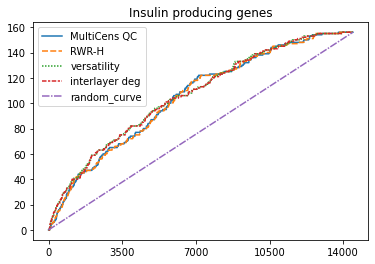

In [48]:
# Generate recall-at-k plot
plt.rcParams.update({'font.size': 10})
plt.title("Insulin producing genes")
plot_df,results, filtered_results, lncRNA_results, merged_df = plot_k_curve_new(genes, g, local_cen_vector, global_cen_vector, target_layer_cen_vector, ground_truth_genes=common_source_genes, filtered=False)


In [19]:
# Save the lncRNA rankings
lncRNA_results.to_csv("../data/paper/insulin_lncRNA_results_corr_SNAP.csv")

In [20]:
# Save gene rankings after applying secretory filter
filtered_results.to_csv("../data/paper/insulin_fileterd_results_corr_SNAP_0.9.csv")

In [21]:
# Save gene rankings
results.to_csv("../data/paper/insulin_results_corr_SNAP_0.9.csv")


# To check the robustness of the method

In [11]:
# Load all genes in the pancreas tissue and their variance
pancreas_tissue_variance_total = pd.read_csv("../pancreas_gene_variance.csv", index_col=0)

In [13]:
# Bin pancreas genes based on their variance
def get_pancreas_tissue_variance(df1, genes):
    df2 = df1.loc[genes].dropna()
    df2 = df2.reindex(genes)
    df2["source_variances_bins"] = pd.cut(df2["source_variances"], bins=[-np.inf, df2["source_variances"].quantile(0.33), df2["source_variances"].quantile(0.66), np.inf], labels=["low", "medium", "high"])
    return df2
pancreas_tissue_variance = get_pancreas_tissue_variance(pancreas_tissue_variance_total, genes)

In [16]:
# Sample a random set of genes
import random

def select_rows_random_excluding_stratified(df2,source_genes_indices):
    # Get the same number of rows as in the source_gene_indices list, but chosen randomly, excluding the rows corresponding to source_gene_indices and stratified by df2["source_variances_bins"]
    all_indexes = set(df2.index)
    source_genes_indices = set(source_genes_indices)
    diff_indexes = list(all_indexes - source_genes_indices)
    low_indexes = [index for index in diff_indexes if df2.loc[index]["source_variances_bins"] == "low"]
    medium_indexes = [index for index in diff_indexes if df2.loc[index]["source_variances_bins"] == "medium"]
    high_indexes = [index for index in diff_indexes if df2.loc[index]["source_variances_bins"] == "high"]
    
    print("index count")
    print(len(low_indexes))
    print(len(medium_indexes))
    print(len(high_indexes))
    
    # Count of source_gene_indices in each bin
    source_genes_indices_low = len([index for index in source_genes_indices if df2.loc[index]["source_variances_bins"] == "low"])
    source_genes_indices_medium = len([index for index in source_genes_indices if df2.loc[index]["source_variances_bins"] == "medium"])
    source_genes_indices_high = len([index for index in source_genes_indices if df2.loc[index]["source_variances_bins"] == "high"])
    print("Number of low values: ", source_genes_indices_low)
    print("Number of medium values: ", source_genes_indices_medium)
    print("Number of high values: ", source_genes_indices_high)
    
    # Selecting the same number of random indexes from each bin as there are in source_gene_indices in that bin
    random.shuffle(low_indexes)
    random.shuffle(medium_indexes)
    random.shuffle(high_indexes)
    random_indexes = low_indexes[:source_genes_indices_low] + medium_indexes[:source_genes_indices_medium] + high_indexes[:source_genes_indices_high]
    return random_indexes

In [17]:
random_source_genes_indices = select_rows_random_excluding_stratified(pancreas_tissue_variance.reset_index(drop=True),source_genes_indices)

index count
4693
4728
4882
Number of low values:  79
Number of medium values:  43
Number of high values:  34


In [ ]:
random_source_genes = [pancreas_tissue_variance.index.tolist()[x] for x in random_source_genes_indices]
random_source_genes

In [19]:
# Load all lncRNAs

lncRNAs = list(np.load("../data/paper/lncRNAs.npy"))

lncRNA_indices = []

# Iterate over lncRNAs
for i, lncRNA in enumerate(lncRNAs):
    # Check if the current lncRNA is present in the genes list
    if lncRNA in genes:
        # Get the index of the current lncRNA in the genes list
        index = genes.index(lncRNA)
        # Append the index to the lncRNA_indices list
        lncRNA_indices.append(index)
len(lncRNA_indices)

634

In [20]:
# Select random set of genes of size cardinality(lncRNAs) startified over gene expression variance
random_lncRNA_indices = select_rows_random_excluding_stratified(pancreas_tissue_variance.reset_index(drop=True),lncRNA_indices)
len(random_lncRNA_indices)

index count
4678
4542
4605
Number of low values:  94
Number of medium values:  229
Number of high values:  311


634

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fontsize" which is no longer supported as of 3.3 and will become an error two minor releases later


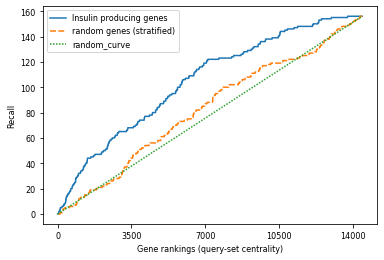

In [40]:
# Generate recall-at-k plot

def get_hits(k_range, ranked_genes, ground_truth_genes):
    hits=np.zeros_like(k_range)
    current_hit_count = 0
    for i in k_range:
        if ranked_genes[i] in ground_truth_genes:
            current_hit_count = current_hit_count +1
        hits[i] = current_hit_count
    return hits



ground_truth_genes_random = [pancreas_tissue_variance.index.tolist()[x] for x in random_source_genes_indices]
ground_truth_genes_source = common_source_genes

cen_vector = g

order = cen_vector[:n].argsort()
ranks = order.argsort()
d = {'gene_name': genes, 'centrality': cen_vector[:n], 'rank': n-ranks}
results = pd.DataFrame(data=d)
results = results.sort_values(by=['centrality'], ascending=False)
ranked_genes = results['gene_name'].tolist()

k_range = np.arange(n)


hits_random = get_hits(k_range, ranked_genes, ground_truth_genes_random)
hits_source = get_hits(k_range, ranked_genes, ground_truth_genes_source)


random_curve = np.cumsum(np.full((n,), hits_source[-1]/n))
#plot_variables = {'local-cen':local_hits, 'global-cen':global_hits, 'target-layer-cen':target_layer_hits, 'query-set centrality': hits, 'RWR': rwr_hits, 'vers': vers_hits, 'vers-target': vers_target_hits, 'inter': interlayer_deg_hits, 'inter-target': interlayer_deg_target_hits, 'random_curve': random_curve}
#plot_variables = {'query-set centrality': hits, 'RWR': rwr_hits, 'vers': vers_hits, 'vers-target': vers_target_hits, 'inter-target': interlayer_deg_target_hits, 'random_curve': random_curve}
#plot_variables = {'query-set centrality': hits, 'RWR': rwr_hits, 'vers': vers_hits, 'vers-target': vers_target_hits, 'inter-target': interlayer_deg_target_hits, 'random_curve': random_curve}
plot_variables = {'Insulin producing genes': hits_source, 'random genes (stratified)': hits_random, 'random_curve': random_curve}
plot_df = pd.DataFrame(data=plot_variables)
sns.lineplot(data=plot_df)    
#plt.xlabel("Top k predictions", labelpad=1)
#plt.ylabel("Recall at k", labelpad=1)
plt.rcParams.update({'font.size': 8})
plt.xlabel("Gene rankings (query-set centrality)")
plt.ylabel("Recall")
plt.xticks(np.arange(0, 15001, 3500))
plt.savefig("./insulin_producing_random_results.svg", dpi=300, fontsize=17, bbox_inches = 'tight')

In [47]:

# This code analyzes the ranking difference between lncRNAs and a random set of genes.

from scipy import stats

def draw_box_plot_with_p_value(results, names1, names2):
    centrality_values1 = []
    centrality_values2 = []
    for name in names1:
        centrality_values1.append(results[results["gene_name"] == name]["rank"].values[0])
    for name in names2:
        centrality_values2.append(results[results["gene_name"] == name]["rank"].values[0])
    plt.boxplot([centrality_values1, centrality_values2], labels=["lncRNAs", "random genes (stratified)"])
    t, pvalue = stats.ttest_ind(centrality_values1, centrality_values2, equal_var=False)
    if pvalue < 0.05:
        print("p-value:",pvalue,",there is a significant difference between centrality values of names1 and names2")
    else:
        print("p-value:",pvalue,",there is no significant difference between centrality values of names1 and names2")
    plt.ylabel("query-set centrality-based rank")
    plt.savefig("./insulin_lncRNA_producing_random_boxplot.svg", dpi=300, fontsize=17, bbox_inches = 'tight')
    plt.show()



p-value: 4.878137269695789e-06 ,there is a significant difference between centrality values of names1 and names2


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fontsize" which is no longer supported as of 3.3 and will become an error two minor releases later


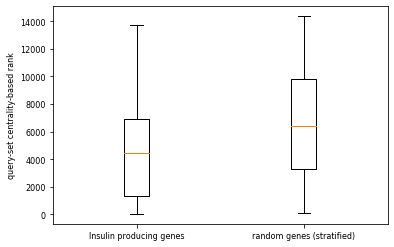

In [46]:
draw_box_plot_with_p_value(results, common_source_genes, random_source_genes)

p-value: 4.949233211468227e-12 ,there is a significant difference between centrality values of names1 and names2


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fontsize" which is no longer supported as of 3.3 and will become an error two minor releases later


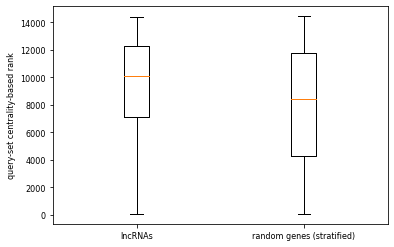

In [48]:
draw_box_plot_with_p_value(results, [genes[x] for x in lncRNA_indices], [genes[x] for x in random_lncRNA_indices])